In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne

In [ ]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_path = "/content/drive/MyDrive/SleepApnea/Data/High_AHI"

In [ ]:
txt_file = os.path.join(data_path, 'OSAA10002 epoch and event list.txt')
edf_file = os.path.join(data_path, 'OSAA10002_New.edf')

In [ ]:
raw = mne.io.read_raw_edf(edf_file, preload=True)

Extracting EDF parameters from /content/drive/MyDrive/SleepApnea/Data/High_AHI/OSAA10002_New.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6951935  =      0.000 ... 27155.996 secs...


In [ ]:
from datetime import datetime

def txt_events_to_dataframe(txt_path, start_line=13):
    """
    Reads a .txt event file and returns a DataFrame.

    Parameters:
        txt_path (str): Path to the event .txt file
        start_line (int): Line where events begin (default: 6 → line 7)

    Returns:
        pd.DataFrame with columns inferred from whitespace
    """
    try:
        with open(txt_path, 'r', encoding='latin-1') as f:
            lines = f.readlines()[start_line:]
            data = [line.strip().split('\t') for line in lines if line.strip()]
            df = pd.DataFrame(data)
            return df
    except Exception as e:
        print(f"Error reading TXT file: {e}")
        return pd.DataFrame()

df = txt_events_to_dataframe(txt_file)

In [ ]:
start_time_edf = raw.info['meas_date']

In [ ]:
def get_line5(filepath):
    try:
        with open(filepath, 'r', encoding='latin-1') as f:
            lines = f.readlines()
            lines = lines[4].strip()
            time = lines.split('\t')[1]
            return time
    except Exception as e:
        return f"Error reading TXT: {e}"


start_time_txt = get_line5(txt_file)

In [ ]:
from datetime import datetime

edf_start = datetime(2016, 8, 15, 22, 14, 53)
edf_date = edf_start.date()
txt_str = "2016-08-15 10:14:53 PM"
txt_start = datetime.strptime(txt_str, "%Y-%m-%d %I:%M:%S %p")

print("EDF start:", edf_start)
print("TXT start:", txt_start)

EDF start: 2016-08-15 22:14:53
TXT start: 2016-08-15 22:14:53


In [ ]:
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)

Changing the Tiem column type from str to pd datetime. Adding column for seconds since start time of PSG study.

In [ ]:
from datetime import datetime

# Step 1: Parse 12-hour time with AM/PM correctly
df['time_only'] = pd.to_datetime(df['Start Time'], format="%I:%M:%S %p").dt.time

# Step 2: Combine with EDF date
edf_date = edf_start.date()
df['Start Time'] = df['time_only'].apply(lambda t: datetime.combine(edf_date, t))
df.loc[df['Start Time'] < edf_start, 'Start Time'] += pd.Timedelta(days=1)

# Step 3: Compute seconds since EDF start
df['seconds_since_start'] = (df['Start Time'] - edf_start).dt.total_seconds()

In [ ]:
sfreq = raw.info['sfreq']
df['start_sample'] = (df['seconds_since_start'] * sfreq).astype(int)

In [ ]:
hypo_df = df[df['Event'].str.contains("hypopnea", case=False, na=False)].copy()

####The code below plots event specified in the txt file. In case you want to plot any specific event, please change the variable i to point to the specific event.

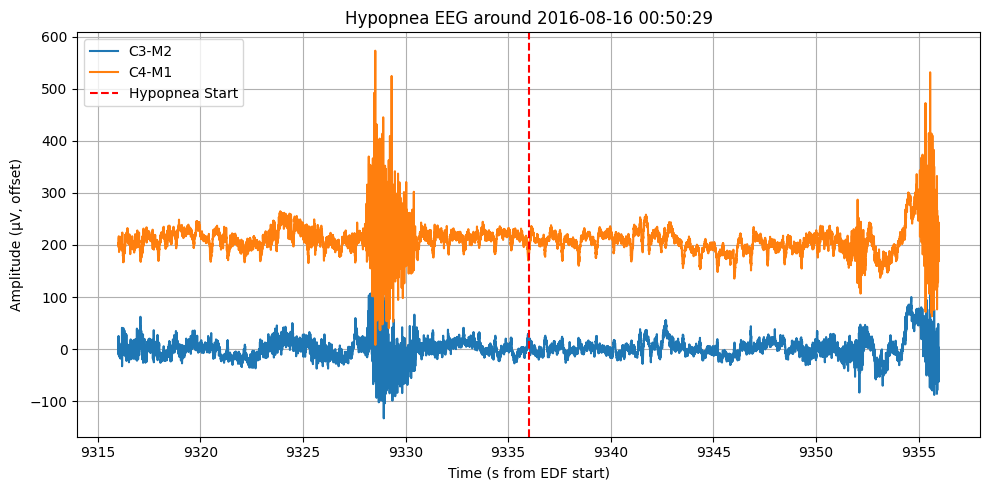

In [ ]:
import matplotlib.pyplot as plt
import mne
from datetime import datetime

# Parameters
window = 20  # seconds before and after
scale = 1e6  # convert Volts to µV
channels_of_interest = ['C3-M2', 'C4-M1']
window_samples = int(window * sfreq)

# Choose one hypopnea event (e.g., index 7)
i = 4
row = hypo_df.iloc[i]
center = row['start_sample']
start = center - window_samples
end = center + window_samples

# Check bounds
if start >= 0 and end <= raw.n_times:
    # Get raw indices for C3, C4, M1, M2
    c3_idx = raw.ch_names.index('C3')
    m1_idx = raw.ch_names.index('M1')
    c4_idx = raw.ch_names.index('C4')
    m2_idx = raw.ch_names.index('M2')

    # Extract EEG windows
    data, times = raw[[c3_idx, m1_idx, c4_idx, m2_idx], start:end]

    # Compute bipolar derivations
    c3_m2 = data[0] - data[3]
    c4_m1 = data[2] - data[1]

    # Combine for plotting
    eeg_segment = np.vstack([c3_m2, c4_m1])

    # Plot
    plt.figure(figsize=(10, 5))
    for ch in range(2):
        plt.plot(times, eeg_segment[ch] * scale + ch * 200, label=channels_of_interest[ch])

    # Add vertical line at event center
    plt.axvline(x=times[window_samples], color='red', linestyle='--', label='Hypopnea Start')

    # Optional: highlight duration
    if 'duration' in row and pd.notnull(row['duration']):
        event_start = times[window_samples]
        event_end = event_start + float(row['duration'])
        plt.axvspan(event_start, event_end, color='red', alpha=0.3, label='Hypopnea Duration')

    plt.title(f"Hypopnea EEG around {row['Start Time']}")
    plt.xlabel("Time (s from EDF start)")
    plt.ylabel("Amplitude (µV, offset)")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    # plt.show()
    plt.savefig(f"/content/drive/MyDrive/SleepApnea/HypoEvents_Plots/eeg_hypopnea_event_{i}.png", dpi=300)
